In [78]:
from landslide4sense.data import LandslideDataSet
from landslide4sense.models import Unet
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import omegaconf
import matplotlib.pyplot as plt
from torch.nn import Upsample, CrossEntropyLoss

In [79]:
cfg = omegaconf.OmegaConf.load("../conf/config.yaml")
cfg

{'data': {'dir': '${hydra:runtime.cwd}/data/', 'train_list': '${hydra:runtime.cwd}/data/train_split_train.txt', 'eval_lists_paths': ['${hydra:runtime.cwd}/data/train_split_train.txt', '${hydra:runtime.cwd}/data/train_split_val.txt'], 'eval_names': ['train', 'val'], 'test_list': '${hydra:runtime.cwd}/data/valid.txt', 'input_size': [128, 128], 'augmentation': {'module': 'landslide4sense.data.augmentations', 'name': 'transforms'}}, 'model': {'restore_from': None, 'module': 'landslide4sense.models', 'name': 'Unet', 'args': {'n_classes': 2}}, 'optimizer': {'restore_from': None, 'module': 'torch.optim', 'name': 'SGD', 'args': {'lr': 0.02, 'weight_decay': 0.0005, 'momentum': 0.9}}, 'loss': {'module': 'torch.nn', 'name': 'CrossEntropyLoss', 'args': {'ignore_index': 255, 'weight': [1, 1.5]}}, 'train': {'start_epoch': 0, 'steps_per_epoch': 34, 'batch_size': 100, 'num_workers': 2, 'num_steps': 10000, 'num_steps_stop': 10000, 'gpu_id': 0, 'snapshot_dir': '/content/drive/MyDrive/data_science_projec

In [80]:
train_dataset = LandslideDataSet(
    "../data/",
    "../data/train_split_train.txt",
    max_iters=cfg.train.num_steps_stop * cfg.train.batch_size,
    set="labeled",
)

In [81]:
train_loader: DataLoader[LandslideDataSet] = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=cfg.train.num_workers,
    pin_memory=True,
)

# Baseline Unet

In [97]:
model = Unet(n_classes=2)
model.train()

Unet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(14, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momen

In [99]:
batch = next(iter(train_loader))
images, labels, _, _ = batch
labels = labels.long()
pred = model(images)
print(pred.size())
pred = pred[:, 1]

torch.Size([1, 2, 128, 128])


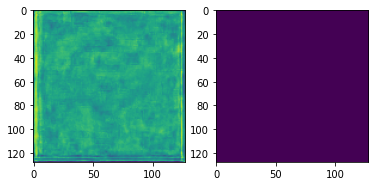

In [100]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(pred.detach().numpy()[0, ...])
ax[1].imshow(labels.detach().numpy()[0, ...])
plt.show()

In [92]:
labels.size()

torch.Size([1, 128, 128])

In [132]:
dice_loss = smp.losses.DiceLoss(mode="multiclass", ignore_index=255)
ce_loss = CrossEntropyLoss(ignore_index=255)

In [96]:
dice_loss(pred, labels)

tensor(0.9922, grad_fn=<MeanBackward0>)

# Unet++

In [133]:
model_pp = smp.UnetPlusPlus(in_channels=14, classes=2)

In [134]:
pred = model_pp(images)

In [135]:
pred.size()

torch.Size([1, 2, 128, 128])

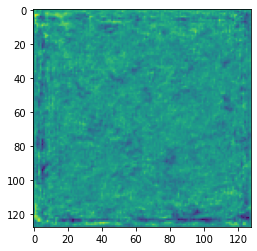

In [136]:
plt.imshow(pred[0, 1, ...].detach().numpy())

In [137]:
labels.size()

torch.Size([1, 128, 128])

In [138]:
pred.size()

torch.Size([1, 2, 128, 128])

In [139]:
dice_loss(pred, labels)

tensor(0.1337, grad_fn=<MeanBackward0>)